# Capstone Project: Spam SMS Prediction

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

### Problem Statement

Recieving spam messages can be annoying. I will be building a prediction model that will accurately classify which texts are spam.

##### Key Terms

- spam: refer to spam SMS or 1
- ham: refer to SMS that are not spam or 0

In [91]:
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib_venn import venn2, venn2_circles

from bs4 import BeautifulSoup

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

import regex as re

In [93]:
spam = pd.read_csv('spam.csv')

In [94]:
spam

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will �_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [95]:
spam = spam.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
spam

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will �_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [96]:
spam = spam.replace(['ham','spam'],[0, 1])
spam

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will �_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [97]:
spam['v1'].value_counts()

0    4825
1     747
Name: v1, dtype: int64

In [98]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


# Text Preprocessing and Feature Engineering

From research an example spam messages normally looks like:

"You won 2 tIckETs to NYC http://www.dbuk.net CALL 08002986030 or send message to: 59123 to get ticket"

Now we will see some sample from the dataset:

In [99]:
#actual text sample
spam.v2[4]

"Nah I don't think he goes to usf, he lives around here though"

In [100]:
#spam text sample
spam.v2[9]

'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030'

In [101]:
#spam text sample
spam.v2[15]

'XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL'

In [102]:
#all spam text
for spam_text in spam.v2:
    print(spam_text)

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though
FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv
Even my brother is not like to speak with me. They treat me like aids patent.
As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Had your mobile 11 months or more? U R entitl

Friendship is not a game to play, It is not a word to say, It doesn\'t start on March and ends on May, It is tomorrow, yesterday, today and e
Nice. Wait...should you be texting right now? I'm not gonna pay your ticket, ya know!
I'm watching lotr w my sis dis aft. So u wan 2 meet me 4 dinner at nite a not?
Why you keeping me away like this
I think its far more than that but find out. Check google maps for a place from your dorm.
My trip was ok but quite tiring lor. Uni starts today but it's ok 4 me cos i'm not taking any modules but jus concentrating on my final yr project.
Have you always been saying welp?
I'm a guy, browsin is compulsory
Ok...
Purity of friendship between two is not about smiling after reading the forwarded message..Its about smiling just by seeing the name. Gud evng musthu
Sorry, I'll call later
(I should add that I don't really care and if you can't I can at least get this dude to fuck off but hey, your money if you want it)
Hello lover! How goes that new job? Are y

Aight, tomorrow around  &lt;#&gt;  it is
House-Maid is the murderer, coz the man was murdered on  &lt;#&gt; th January.. As public holiday all govt.instituitions are closed,including post office..understand?
YOUR CHANCE TO BE ON A REALITY FANTASY SHOW call now = 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national = rate call.
I actually did for the first time in a while. I went to bed not too long after i spoke with you. Woke up at 7. How was your night?
See you there! 
I dont understand your message.
Crucify is c not s. You should have told me earlier.
Idk. You keep saying that you're not, but since he moved, we keep butting heads over freedom vs. responsibility. And i'm tired. I have so much other shit to deal with that i'm barely keeping myself together once this gets added to it.
Fuck cedar key and fuck her (come over anyway tho)
twenty past five he said will this train have been to durham already or not coz i am in a reserved seat
Hey Boys. Want ho

1 I don't have her number and 2 its gonna be a massive pain in the ass and i'd rather not get involved if that's possible
Anytime lor...
Do you want a new Video handset? 750 any time any network mins? UNLIMITED TEXT? Camcorder? Reply or Call now 08000930705 for del Sat AM
Purity of friendship between two is not about smiling after reading the forwarded message..Its about smiling just by seeing the name. Gud evng
Ur balance is now �600. Next question: Complete the landmark, Big, A. Bob, B. Barry or C. Ben ?. Text A, B or C to 83738. Good luck!
Me fine..absolutly fine
K and you're sure I don't have to have consent forms to do it :V
Ur TONEXS subscription has been renewed and you have been charged �4.50. You can choose 10 more polys this month. www.clubzed.co.uk *BILLING MSG*
If you don't, your prize will go to another customer. T&C at www.t-c.biz 18+ 150p/min Polo Ltd Suite 373 London W1J 6HL Please call back if busy
How much is torch in 9ja.
Doing nothing, then u not having dinner w us?

### Normalization

From the example and research there are a lot going on in a spam text like, phone number, website, emails, currency signs, capital letters and punctuations. To make sure all the text are the same I will normalized them

This will be done by:
- Replacing URLs with "urllink"
- Replacing text number with "textnumb" (5 digit)
- Replacing phone numbers with "phonenumb" (10-11 digit)
- Removing symbols
- Removing numbers
- Replacing capital letters

In [103]:
example = "You won 2 tIckETs to NYC http://www.dbuk.net CALL 08002986030 or send message to: 59123 to get ticket"

In [104]:
#replacing the url links
url = re.sub(r"(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)","urllink",example)
url

'You won 2 tIckETs to NYC urllink CALL 08002986030 or send message to: 59123 to get ticket'

In [105]:
#replacing text number
textnumb = re.sub(r"\b\d{5}\b","textnumb",url)
textnumb

'You won 2 tIckETs to NYC urllink CALL 08002986030 or send message to: textnumb to get ticket'

In [106]:
#replacing phone number
phone = re.sub(r"\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b", "phonenumb",url)
phone

'You won 2 tIckETs to NYC urllink CALL phonenumb or send message to: 59123 to get ticket'

In [107]:
#removing numbers, symbols and non letters
letters_only = re.sub("[^a-zA-Z]", " ", phone)
letters_only

'You won   tIckETs to NYC urllink CALL phonenumb or send message to        to get ticket'

In [108]:
lowercase = letters_only.lower().split()
lowercase

['you',
 'won',
 'tickets',
 'to',
 'nyc',
 'urllink',
 'call',
 'phonenumb',
 'or',
 'send',
 'message',
 'to',
 'to',
 'get',
 'ticket']

### Stop Words

Some words in the English language, while necessary, don't contribute much to the meaning of a phrase. These words, such as "when", "had", "those" or "before", are called stop words and should be filtered out. 

In [109]:
stop_words = nltk.corpus.stopwords.words('english')

In [110]:
words = [w for w in lowercase if not w in stop_words]
words

['tickets',
 'nyc',
 'urllink',
 'call',
 'phonenumb',
 'send',
 'message',
 'get',
 'ticket']

### Stemming, Tolkenizing and Lemmatizing

The three method allow me to clean and separate wods to their stem, root and individual words. I will be exploring what each process do to the sample text.

In [111]:
porter = PorterStemmer()
ps = [porter.stem(i) for i in words]
ps

['ticket',
 'nyc',
 'urllink',
 'call',
 'phonenumb',
 'send',
 'messag',
 'get',
 'ticket']

In [112]:
tokenizer = RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(example)
tokens

['You',
 'won',
 '2',
 'tIckETs',
 'to',
 'NYC',
 'http',
 'www',
 'dbuk',
 'net',
 'CALL',
 '08002986030',
 'or',
 'send',
 'message',
 'to',
 '59123',
 'to',
 'get',
 'ticket']

In [113]:
lemmatizer = WordNetLemmatizer()
lem = [lemmatizer.lemmatize(i) for i in words]
lem

['ticket',
 'nyc',
 'urllink',
 'call',
 'phonenumb',
 'send',
 'message',
 'get',
 'ticket']

### Clean Text Function

From the text preprocessing and feature engineering I combined the process together to clean the SMS sample.

From above, stemming seemed to work best as it shorten the words to their stem which is suitable for SMS messages as text can contain abbreviations, slang and grammatical words, using stemming will give me the root of the words to work with when modeling.

In the cleaning process I decided to identified the phone numebers, url lins and remove non text. I chose to replace them with identifying words like "urllink", "textnumb" and "phonenumb" because I believe these are defining factor of what a spam text have.

In [114]:
def text_to_words(raw_text):
    # 1. Remove non-letters
    url = re.sub(r"(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)","urllink", raw_text) #removing url links
    remove = re.sub(r"&lt;#&gt", "",url) #removing &lt;#&gt
    textnumb = re.sub(r"\b\d{5}\b","textnumb",remove) #removing text number (5 digits)
    phone = re.sub(r"\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b","phonenumb",textnumb) #removing phone number (11 digits)
    letters_only = re.sub("[^a-zA-Z]", " ", phone) #removing all non letters

    # 2. Convert to lower case, split into individual words.
    lowercase = letters_only.lower().split()
    
    # 3. Remove stopwords.
    stop_words = nltk.corpus.stopwords.words('english')   
    words = [w for w in lowercase if not w in stop_words]
    
    # 4. Stemming
    porter = PorterStemmer()
    ps = [porter.stem(i) for i in words]
    
    # 5. Join the words back into one string separated by space, 
    return(" ".join(ps))

In [115]:
#test clean text with example
print('original text:',example)
print('clean text:',text_to_words(example))

original text: You won 2 tIckETs to NYC http://www.dbuk.net CALL 08002986030 or send message to: 59123 to get ticket
clean text: ticket nyc urllink call phonenumb send messag textnumb get ticket


In [116]:
#test clean text with url link sample
print('original text:',spam.v2[12])
print('clean text:',text_to_words(spam.v2[12]))

original text: URGENT! You have won a 1 week FREE membership in our �100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
clean text: urgent week free membership prize jackpot txt word claim textnumb c urllink lccltd pobox ldnw rw


In [117]:
#test clean text with url link sample
print('original text:',spam.v2[15])
print('clean text:',text_to_words(spam.v2[15]))

original text: XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL
clean text: xxxmobilemovieclub use credit click wap link next txt messag click urllink urllink


In [118]:
#test clean text with phone number sample
print('original text:',spam.v2[9])
print('clean text:',text_to_words(spam.v2[9]))

original text: Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
clean text: mobil month u r entitl updat latest colour mobil camera free call mobil updat co free phonenumb


### Clean Text

Now we will use the function on the provided SMS text.

In [119]:
clean_text=[]

for text in spam['v2']:
    clean_text.append(text_to_words(text))

In [120]:
clean_text

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'ok lar joke wif u oni',
 'free entri wkli comp win fa cup final tkt st may text fa textnumb receiv entri question std txt rate c appli',
 'u dun say earli hor u c alreadi say',
 'nah think goe usf live around though',
 'freemsg hey darl week word back like fun still tb ok xxx std chg send rcv',
 'even brother like speak treat like aid patent',
 'per request mell mell oru minnaminungint nurungu vettam set callertun caller press copi friend callertun',
 'winner valu network custom select receivea prize reward claim call phonenumb claim code kl valid hour',
 'mobil month u r entitl updat latest colour mobil camera free call mobil updat co free phonenumb',
 'gonna home soon want talk stuff anymor tonight k cri enough today',
 'six chanc win cash pound txt csh send textnumb cost p day day tsandc appli repli hl info',
 'urgent week free membership prize jackpot txt word claim textnumb c urllink lccltd pobox ld

In [121]:
spam['clean_text'] = clean_text
spam

,v1,v2,clean_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,nd time tri contact u u pound prize claim easi...
5568,0,Will �_ b going to esplanade fr home?,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",piti mood suggest
5570,0,The guy did some bitching but I acted like i'd...,guy bitch act like interest buy someth els nex...


# Data Visualizations


In this section I will be creating visualization to represent the word frequency, count and common words through the use of word clouds and bar charts.

### Word Cloud

Identifing the words that are shown most in SMS.

In [122]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def draw_wordcloud(data, plot_title=None):
    wordcloud = WordCloud(
        scale=7,
        max_words=500,
        stopwords=stopwords,
        width = 800,
        height = 800,
        background_color='white',
        colormap='Greens',
        contour_width=3,
        contour_color='green').generate(''.join(data))
    
    plt.figure(figsize=(16,10), facecolor='white')
    plt.imshow(wordcloud)
    plt.title(plot_title, fontsize=20, pad=50)
    plt.axis("off")
    plt.show()

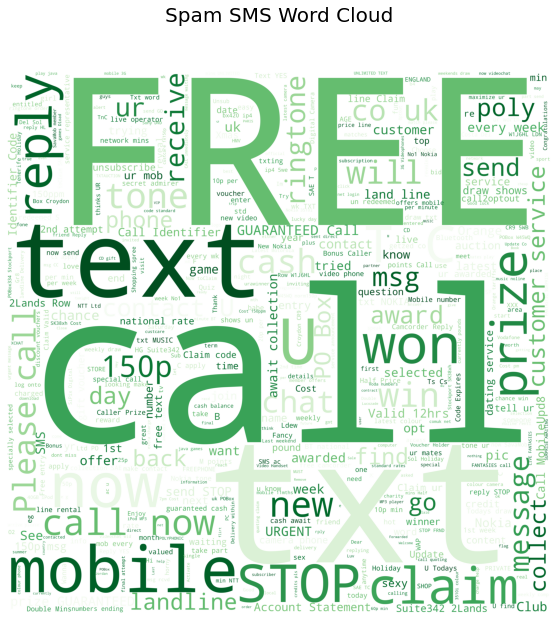

In [123]:
draw_wordcloud(spam[spam.v1==1].v2, "Spam SMS Word Cloud")

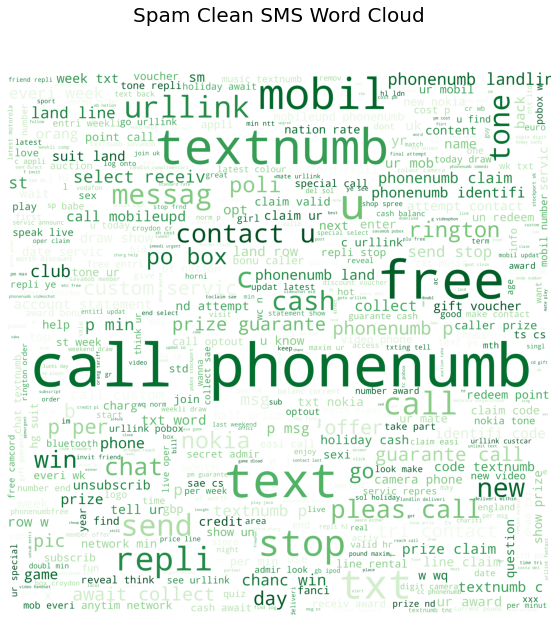

In [124]:
draw_wordcloud(spam[spam.v1==1].clean_text, "Spam Clean SMS Word Cloud")

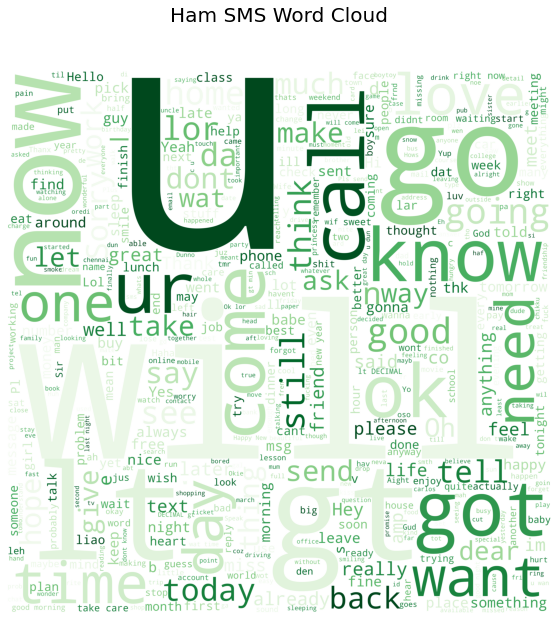

In [125]:
draw_wordcloud(spam[spam.v1==0].v2, "Ham SMS Word Cloud")

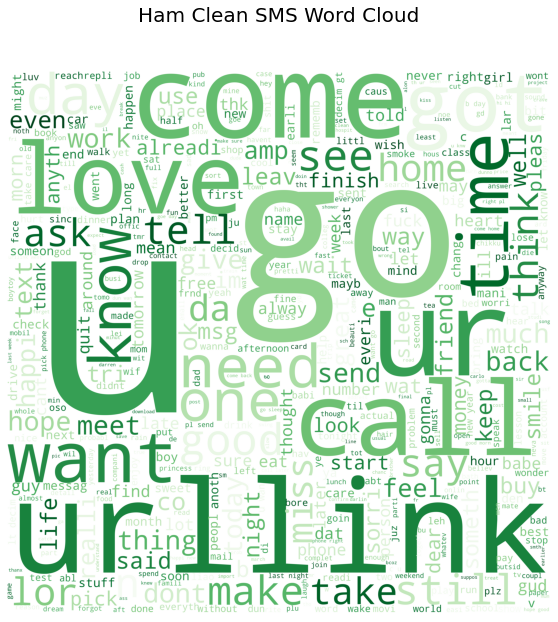

In [126]:
draw_wordcloud(spam[spam.v1==0].clean_text, "Ham Clean SMS Word Cloud")

### Word Count

In the word count we can see that the most repeated words used in SMS

In [127]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvec = CountVectorizer(stop_words='english')

tvec = TfidfVectorizer(stop_words='english')

In [128]:
#spam cvec count
cvec_spam = cvec.fit_transform(spam[spam.v1==1].clean_text)
cvec_spam_df = pd.DataFrame(cvec_spam.todense(),columns=cvec.get_feature_names())
cvec_spam_count = cvec_spam_df.sum(axis=0)
cvec_spam_count.sort_values(ascending=False).head(10)

phonenumb    408
textnumb     252
free         227
txt          176
urllink      168
text         145
ur           144
mobil        141
stop         126
claim        115
dtype: int64

In [129]:
#spam tvec count
tvec_spam = tvec.fit_transform(spam[spam.v1==1].clean_text)
tvec_spam_df = pd.DataFrame(tvec_spam.todense(),columns=cvec.get_feature_names())
tvec_spam_count = tvec_spam_df.sum(axis=0)
tvec_spam_count.sort_values(ascending=False).head(10)

phonenumb    43.263800
free         30.752238
textnumb     30.422437
urllink      24.719233
mobil        22.779008
txt          22.680742
text         22.030669
claim        21.785952
prize        21.085403
ur           21.048748
dtype: float64

In [130]:
#nonspam cvec count
cvec_notspam = cvec.fit_transform(spam[spam.v1==0].clean_text)
cvec_notspam_df = pd.DataFrame(cvec_notspam.todense(),columns=cvec.get_feature_names())
cvec_notspam_count = cvec_notspam_df.sum(axis=0)
cvec_notspam_count.sort_values(ascending=False).head(10)

urllink    313
come       296
ok         279
know       248
like       244
day        244
love       243
ur         241
got        233
time       231
dtype: int64

In [131]:
#nonspam tvec count
tvec_notspam = tvec.fit_transform(spam[spam.v1==0].clean_text)
tvec_notspam_df = pd.DataFrame(tvec_notspam.todense(),columns=cvec.get_feature_names())
tvec_notspam_count = tvec_notspam_df.sum(axis=0)
tvec_notspam_count.sort_values(ascending=False).head(10)

ok         103.399050
come        81.840192
urllink     69.622195
time        62.147037
good        61.527008
know        60.834040
sorri       60.179324
later       58.881241
like        58.868294
got         57.260237
dtype: float64

In [132]:
def word_count(cvec_data,tvec_data,title1,title2):
    plt.figure(figsize=(22,16), facecolor='white')

    plt.subplot(2,2,1)
    cvec_data.sort_values().tail(10).plot(kind='barh')
    plt.title(title1)
    plt.xlabel('Count')
    plt.ylabel('Word')

    plt.subplot(2,2,2)
    tvec_data.sort_values().tail(10).plot(kind='barh')
    plt.title(title2)
    plt.xlabel('TFIDF Value')
    plt.ylabel('Word')

    plt.tight_layout()

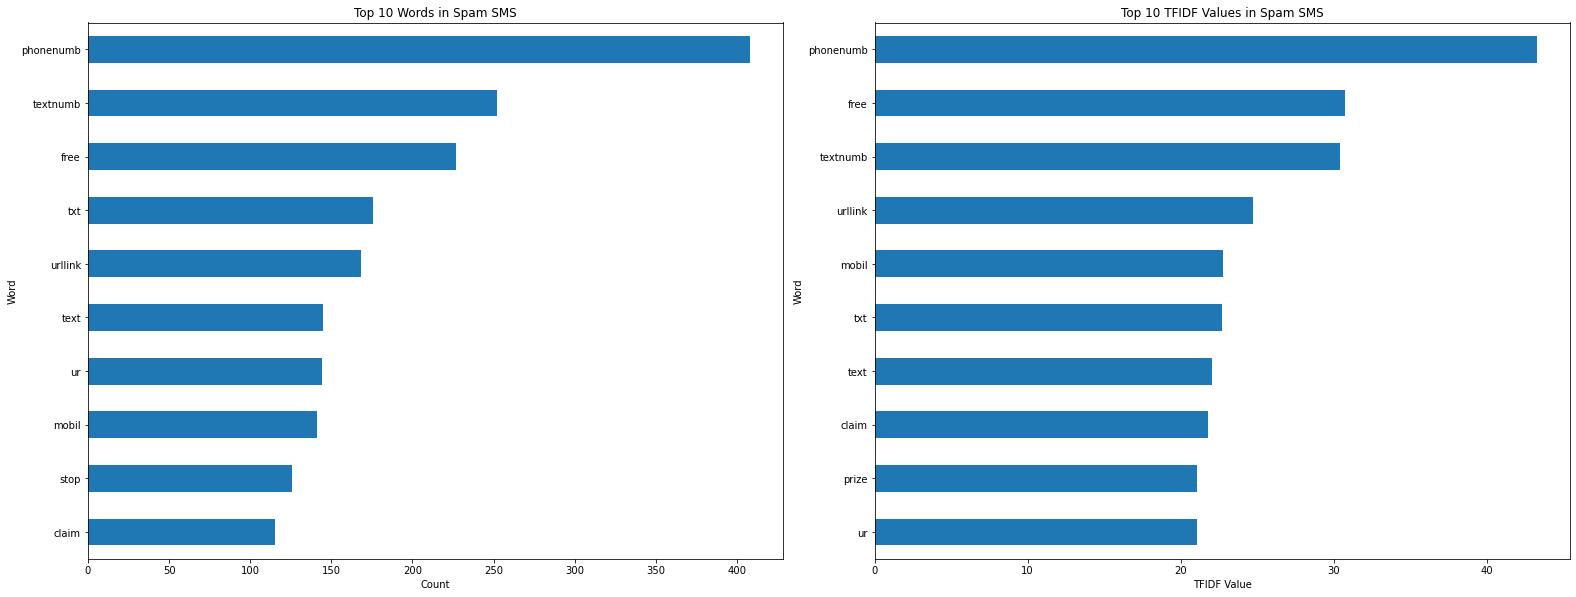

In [133]:
word_count(cvec_data=cvec_spam_count,tvec_data=tvec_spam_count,title1='Top 10 Words in Spam SMS',title2='Top 10 TFIDF Values in Spam SMS')

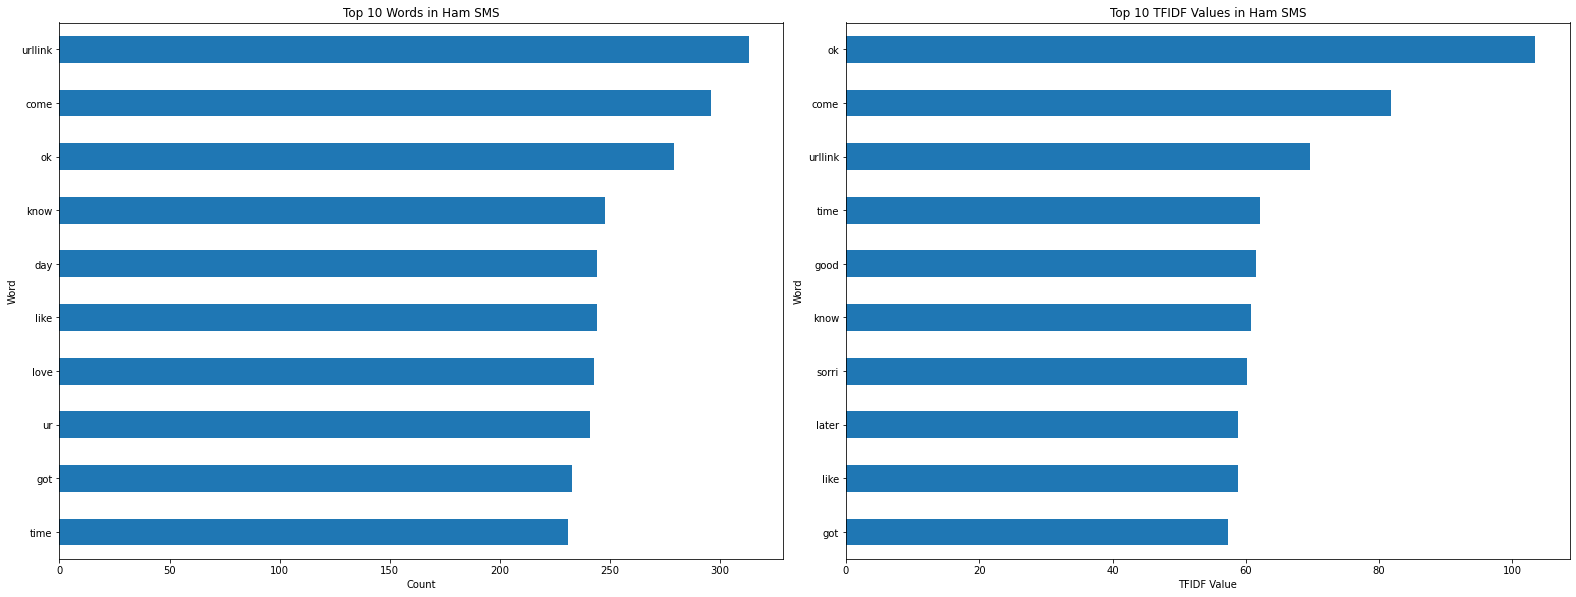

In [134]:
word_count(cvec_data=cvec_notspam_count,tvec_data=tvec_notspam_count,title1='Top 10 Words in Ham SMS',title2='Top 10 TFIDF Values in Ham SMS')

### Word Frequencies

The word count allow us to defined how many times a word is repeated however, it is hard to understand from just count. So I will be exploring how many time the word is repeted in proportion to the toal word count shown as frequency in %:

In [135]:
spam_freq = pd.DataFrame(cvec_spam_count)
spam_freq.reset_index(inplace=True)
spam_freq.rename(columns = {'index':'words',0:'count'},inplace = True)
spam_freq['freq'] = spam_freq['count'] / len(cvec_spam_count) * 100
spam_freq.sort_values(by='count',ascending=False, inplace=True)
spam_freq

,words,count,freq
972,phonenumb,408,25.388923
1363,textnumb,252,15.681394
482,free,227,14.125700
1428,txt,176,10.952085
1463,urllink,168,10.454263
...,...,...,...
749,lord,1,0.062228
750,lose,1,0.062228
754,loung,1,0.062228
757,low,1,0.062228


In [136]:
notspam_freq = pd.DataFrame(cvec_notspam_count)
notspam_freq.reset_index(inplace=True)
notspam_freq.rename(columns = {'index':'words',0:'count'},inplace = True)
notspam_freq['freq'] = notspam_freq['count'] / len(cvec_notspam_count) * 100
notspam_freq.sort_values(by='count',ascending=False, inplace=True)
notspam_freq

,words,count,freq
4795,urllink,313,6.043638
872,come,296,5.715389
3130,ok,279,5.387140
2432,know,248,4.788569
2545,like,244,4.711334
...,...,...,...
2327,jjc,1,0.019309
2331,jod,1,0.019309
2336,joker,1,0.019309
2340,jon,1,0.019309


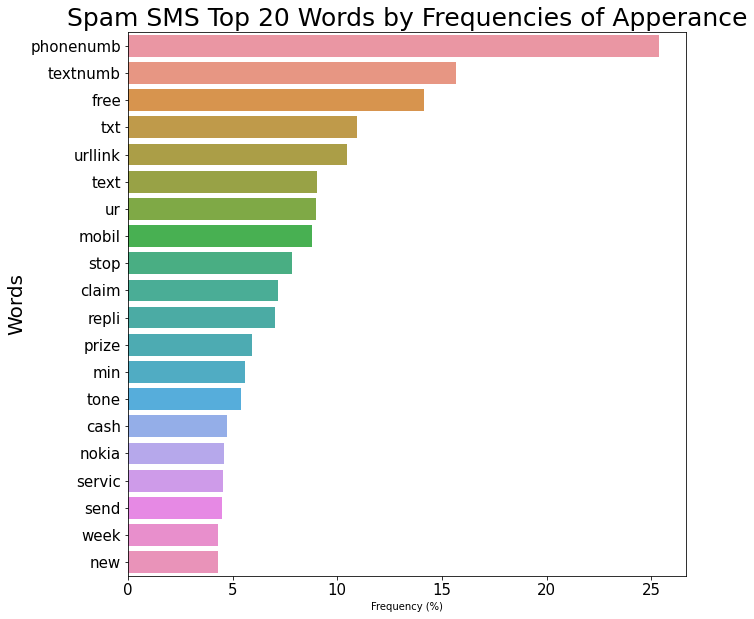

In [137]:
plt.figure(figsize=(10,10))
plt.title('Spam SMS Top 20 Words by Frequencies of Apperance',fontsize=25)

sns.barplot(data=spam_freq.head(20),x='freq',y='words',orient='h')

plt.xlabel('Frequency (%)',fontsize=10)
plt.ylabel('Words',fontsize=20)
plt.tick_params(labelsize=15)

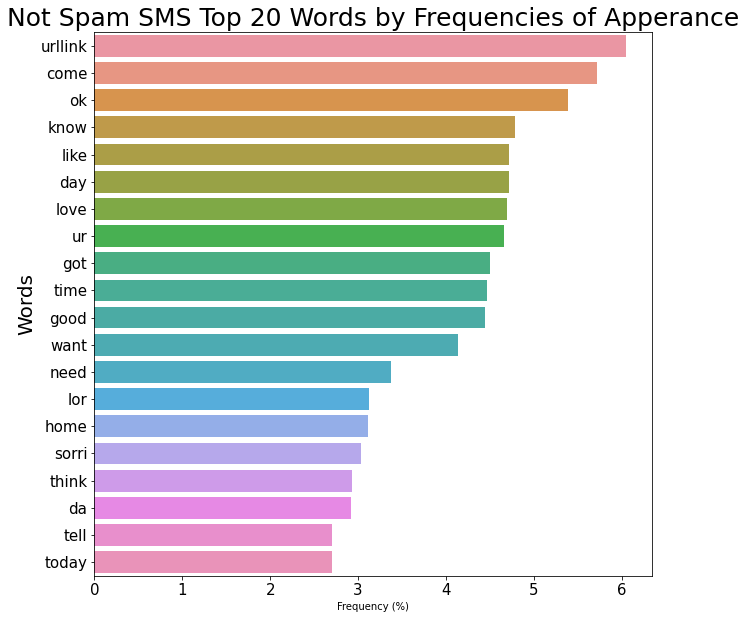

In [138]:
plt.figure(figsize=(10,10))
plt.title('Not Spam SMS Top 20 Words by Frequencies of Apperance',fontsize=25)

sns.barplot(data=notspam_freq.head(20),x='freq',y='words',orient='h')

plt.xlabel('Frequency (%)',fontsize=10)
plt.ylabel('Words',fontsize=20)
plt.tick_params(labelsize=15)

# Modeling

In this section I will be using estimators to create prediction models to predict which SMS is a spam or ham. I have create a modeling fuction called 'modeling' that automates different estimators and vectorized with customized parameters input, and print out each model accuracy score.

The model is being judged on their accuracy score and confusion matrix.

In [139]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import tensorflow as tf

from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [140]:
# Get the number of reviews based on the dataframe size.
sms = spam.shape[0]
print(f'There are {sms} SMS.')

There are 5572 SMS.


In [141]:
X = spam[['clean_text']]
y = spam['v1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [142]:
clean_text_train=[]
clean_text_test=[]

for text in X_train['clean_text']:
    clean_text_train.append(text)
    

for text in X_test['clean_text']:
    clean_text_test.append(text)

### Modeling Functions

In [143]:
def modeling(estimator,vectorizer,y_train,max_features=None, min_df=1, max_df=1.0, ngram_range=(1,1),n_neighbors=5):
    print('Estimator Used:', estimator)
    print('Vectorizer:', vectorizer)
    
    # Instantiate the transformer.
    cvec = CountVectorizer(analyzer = "word",
                           tokenizer = None,
                           preprocessor = None,
                           stop_words = None,
                           max_features=max_features,
                           min_df=min_df,
                           max_df=max_df,
                           ngram_range=ngram_range) 

    tvec = TfidfVectorizer(analyzer = "word",
                           tokenizer = None,
                           preprocessor = None,
                           stop_words = None,
                           max_features=max_features,
                           min_df=min_df,
                           max_df=max_df,
                           ngram_range=ngram_range)
    if vectorizer == 'cvec':
        train_data_features = cvec.fit_transform(clean_text_train)
        test_data_features = cvec.transform(clean_text_test)
        print('Train Data Shape',train_data_features.shape)
        print('Test Data Shape',test_data_features.shape)
        
    elif vectorizer == 'tvec':
        train_data_features = tvec.fit_transform(clean_text_train)
        test_data_features = tvec.transform(clean_text_test)
        print('Train Data Shape',train_data_features.shape)
        print('Test Data Shape',test_data_features.shape)
    
    if estimator == 'log':
        log = LogisticRegression(solver = 'lbfgs')
        log.fit(train_data_features, y_train)
        print('Train Logistic regression Accuracy:', cross_val_score(log,train_data_features,y_train,cv=5).mean())
        print('Test Logistic regression Accuracy:', cross_val_score(log,test_data_features, y_test,cv=5).mean())
        return log.predict(test_data_features)
    
    elif estimator == 'knn':
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(train_data_features, y_train)
        print('Train KNN regression Accuracy:', cross_val_score(knn,train_data_features,y_train,cv=5).mean())
        print('Test KNN regression Accuracy:', cross_val_score(knn,test_data_features, y_test,cv=5).mean())
        return knn.predict(test_data_features)
        
    elif estimator == 'bayes':
        nb = MultinomialNB()
        nb.fit(train_data_features, y_train)
        print('Train Naive Bayes regression Accuracy:', cross_val_score(nb,train_data_features,y_train,cv=5).mean())
        print('Test Naive Bayes regression Accuracy:', cross_val_score(nb,test_data_features, y_test,cv=5).mean())
        return nb.predict(test_data_features)
    
    elif estimator == 'tree':
        tree = DecisionTreeClassifier()
        tree.fit(train_data_features, y_train)
        print('Train Decision Tree regression Accuracy:', cross_val_score(tree,train_data_features,y_train,cv=5).mean())
        print('Test Decision Tree regression Accuracy:', cross_val_score(tree,test_data_features, y_test,cv=5).mean())
        return tree.predict(test_data_features)

    else:
        print('ERROR Parameters')

In [144]:
def confusion_eval(y_test,prediction):
    tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
  
    print('All Data:', len(y_test))
    print('Correctly Predict that the SMS is a spam (TP):',tp)
    print('Correctly Predict that the SMS is is a ham (TN):',tn)
    print('Incorrectly Predict that the SMS is a spam (FP):',fp)
    print('Incorrectly Predict that the SMS is a ham (FN):',fn)

In [145]:
def confusion_score(y_test,prediction):
    tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
    
    print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
    print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
    print('Precision: {}'.format(round(tp/(tp+fp),4)))
    print('Recall: {}'.format(round(tp/(tp+fn),4)))
    print('Specificity: {}'.format(round(tn/(tn+fp),4)))

### Logistic Regression

First we will explore Logistic Regression, starting by comparing the vectorizor to see which gives the best accuracy score and will be using that as the default vectorizer and adjust the parameters to find the highest accuracy socre.

In [146]:
predict_log_tvec = modeling(estimator='log',vectorizer='tvec',y_train=y_train)

Estimator Used: log
Vectorizer: tvec
Train Data Shape (4457, 5453)
Test Data Shape (1115, 5453)
Train Logistic regression Accuracy: 0.9643236047570876
Test Logistic regression Accuracy: 0.9156950672645741


In [147]:
predict_log_cvec = modeling(estimator='log',vectorizer='cvec',y_train=y_train)

Estimator Used: log
Vectorizer: cvec
Train Data Shape (4457, 5453)
Test Data Shape (1115, 5453)
Train Logistic regression Accuracy: 0.9845163141127266
Test Logistic regression Accuracy: 0.9721973094170403


In [148]:
predict_log_param = modeling(estimator='log',vectorizer='cvec',y_train=y_train,max_features=3000, min_df=2, max_df=0.5,ngram_range=(1,2))

Estimator Used: log
Vectorizer: cvec
Train Data Shape (4457, 3000)
Test Data Shape (1115, 3000)
Train Logistic regression Accuracy: 0.9842920988660898
Test Logistic regression Accuracy: 0.9730941704035875


##### Evaluate Logistic Model

From above we see that the best model uses CountVectorizer with its default parameters giving us a 0.98 accuracy score.

In [149]:
confusion_eval(y_test,predict_log_cvec)

All Data: 1115
Correctly Predict that the SMS is a spam (TP): 137
Correctly Predict that the SMS is is a ham (TN): 964
Incorrectly Predict that the SMS is a spam (FP): 1
Incorrectly Predict that the SMS is a ham (FN): 13


In [150]:
confusion_score(y_test,predict_log_cvec)

Accuracy: 0.9874
Misclassification rate: 0.0126
Precision: 0.9928
Recall: 0.9133
Specificity: 0.999


In [151]:
best_log = pd.DataFrame(confusion_matrix(y_test,predict_log_cvec),
                          columns=['predict Ham SMS', 'predict Spam SMS'],
                          index=['actual Ham SMS', 'actual Spam SMS'])
best_log

,predict Ham SMS,predict Spam SMS
actual Ham SMS,964,1
actual Spam SMS,13,137


### KNN

Now we will explore KNN Regression, starting by comparing the vectorizor to see which gives the best accuracy score and will be using that as the default vectorizer and adjust the parameters to find the highest accuracy socre.

In [152]:
predict_knn_tvec = modeling(estimator='knn',vectorizer='tvec',y_train=y_train)

Estimator Used: knn
Vectorizer: tvec
Train Data Shape (4457, 5453)
Test Data Shape (1115, 5453)
Train KNN regression Accuracy: 0.9120482352171442
Test KNN regression Accuracy: 0.8798206278026907


In [153]:
predict_knn_cvec = modeling(estimator='knn',vectorizer='cvec',y_train=y_train)

Estimator Used: knn
Vectorizer: cvec
Train Data Shape (4457, 5453)
Test Data Shape (1115, 5453)
Train KNN regression Accuracy: 0.9273041828348255
Test KNN regression Accuracy: 0.8878923766816144


In [154]:
knn_cvec_n10 = modeling(estimator='knn',vectorizer='cvec',y_train=y_train,n_neighbors=10)

Estimator Used: knn
Vectorizer: cvec
Train Data Shape (4457, 5453)
Test Data Shape (1115, 5453)
Train KNN regression Accuracy: 0.9012778507546819
Test KNN regression Accuracy: 0.8681614349775785


In [155]:
knn_cvec_n20 = modeling(estimator='knn',vectorizer='cvec',y_train=y_train,n_neighbors=20)

Estimator Used: knn
Vectorizer: cvec
Train Data Shape (4457, 5453)
Test Data Shape (1115, 5453)
Train KNN regression Accuracy: 0.8826559063479842
Test KNN regression Accuracy: 0.865470852017937


In [156]:
knn_cvec_n30 = modeling(estimator='knn',vectorizer='cvec',y_train=y_train,n_neighbors=30)

Estimator Used: knn
Vectorizer: cvec
Train Data Shape (4457, 5453)
Test Data Shape (1115, 5453)
Train KNN regression Accuracy: 0.8716625648613692
Test KNN regression Accuracy: 0.865470852017937


In [157]:
knn_cvec_param = modeling(estimator='knn',vectorizer='cvec',y_train=y_train,max_features=3000,min_df=50, max_df=0.5,ngram_range=(1,2))

Estimator Used: knn
Vectorizer: cvec
Train Data Shape (4457, 128)
Test Data Shape (1115, 128)
Train KNN regression Accuracy: 0.9589396707483404
Test KNN regression Accuracy: 0.9443946188340806


##### Evaluate KNN
From above the best model use Countvectorizer with the parameters of 3000 for max_features, 50 for min_df, 0.5 for max_df and (1,22) for ngram_range, givin a 96% prediction accuracy

In [158]:
confusion_eval(y_test,knn_cvec_param)

All Data: 1115
Correctly Predict that the SMS is a spam (TP): 113
Correctly Predict that the SMS is is a ham (TN): 964
Incorrectly Predict that the SMS is a spam (FP): 1
Incorrectly Predict that the SMS is a ham (FN): 37


In [159]:
confusion_score(y_test,knn_cvec_param)

Accuracy: 0.9659
Misclassification rate: 0.0341
Precision: 0.9912
Recall: 0.7533
Specificity: 0.999


In [160]:
best_knn = pd.DataFrame(confusion_matrix(y_test,knn_cvec_param),
                          columns=['predict Ham SMS', 'predict Spam SMS'],
                          index=['actual Ham SMS', 'actual Spam SMS'])
best_knn

,predict Ham SMS,predict Spam SMS
actual Ham SMS,964,1
actual Spam SMS,37,113


### Naive Bayes

Now, we will explore Naive Bayes Estimator, starting by comparing the vectorizor to see which gives the best accuracy score and will be using that as the default vectorizer and adjust the parameters to find the highest accuracy socre

In [161]:
predict_bayes_tvec = modeling(estimator='bayes',vectorizer='tvec',y_train=y_train)

Estimator Used: bayes
Vectorizer: tvec
Train Data Shape (4457, 5453)
Test Data Shape (1115, 5453)
Train Naive Bayes regression Accuracy: 0.9706059096193626
Test Naive Bayes regression Accuracy: 0.9094170403587445


In [162]:
predict_bayes_cvec = modeling(estimator='bayes',vectorizer='cvec',y_train=y_train)

Estimator Used: bayes
Vectorizer: cvec
Train Data Shape (4457, 5453)
Test Data Shape (1115, 5453)
Train Naive Bayes regression Accuracy: 0.9762155687417271
Test Naive Bayes regression Accuracy: 0.9802690582959641


In [163]:
bayes_params = modeling(estimator='bayes',vectorizer='cvec',y_train=y_train,max_features=6000)

Estimator Used: bayes
Vectorizer: cvec
Train Data Shape (4457, 5453)
Test Data Shape (1115, 5453)
Train Naive Bayes regression Accuracy: 0.9762155687417271
Test Naive Bayes regression Accuracy: 0.9802690582959641


##### Evaluate Naive Bayes

From above the best model is with CountVectorizer with it default parameter giving 98% prediction accuracy.

In [164]:
confusion_eval(y_test,bayes_params)

All Data: 1115
Correctly Predict that the SMS is a spam (TP): 142
Correctly Predict that the SMS is is a ham (TN): 959
Incorrectly Predict that the SMS is a spam (FP): 6
Incorrectly Predict that the SMS is a ham (FN): 8


In [165]:
confusion_score(y_test,bayes_params)

Accuracy: 0.9874
Misclassification rate: 0.0126
Precision: 0.9595
Recall: 0.9467
Specificity: 0.9938


In [166]:
best_bayes = pd.DataFrame(confusion_matrix(y_test,bayes_params),
                          columns=['predict Ham SMS', 'predict Spam SMS'],
                          index=['actual Ham SMS', 'actual Spam SMS'])
best_bayes

,predict Ham SMS,predict Spam SMS
actual Ham SMS,959,6
actual Spam SMS,8,142


### Decision Tree

Lastly, we will explore Decision Tree Estimator, starting by comparing the vectorizor to see which gives the best accuracy score and will be using that as the default vectorizer and adjust the parameters to find the highest accuracy socre

In [167]:
predict_tree_tvec = modeling(estimator='tree',vectorizer='tvec',y_train=y_train)

Estimator Used: tree
Vectorizer: tvec
Train Data Shape (4457, 5453)
Test Data Shape (1115, 5453)
Train Decision Tree regression Accuracy: 0.9789089197908332
Test Decision Tree regression Accuracy: 0.9766816143497759


In [168]:
predict_tree_cvec = modeling(estimator='tree',vectorizer='cvec',y_train=y_train)

Estimator Used: tree
Vectorizer: cvec
Train Data Shape (4457, 5453)
Test Data Shape (1115, 5453)
Train Decision Tree regression Accuracy: 0.9777853271126815
Test Decision Tree regression Accuracy: 0.9739910313901344


In [169]:
predict_tree_3000 = modeling(estimator='tree',vectorizer='cvec',y_train=y_train,max_features=2000,min_df=8)

Estimator Used: tree
Vectorizer: cvec
Train Data Shape (4457, 850)
Test Data Shape (1115, 850)
Train Decision Tree regression Accuracy: 0.9757681448264408
Test Decision Tree regression Accuracy: 0.9730941704035875


##### Evaluate Decision Tree

From above the best model is used with CountVectorizer with 2000 as max_feature and 8 as min_df.

In [170]:
confusion_eval(y_test,predict_tree_3000)

All Data: 1115
Correctly Predict that the SMS is a spam (TP): 138
Correctly Predict that the SMS is is a ham (TN): 955
Incorrectly Predict that the SMS is a spam (FP): 10
Incorrectly Predict that the SMS is a ham (FN): 12


In [171]:
confusion_score(y_test,predict_tree_3000)

Accuracy: 0.9803
Misclassification rate: 0.0197
Precision: 0.9324
Recall: 0.92
Specificity: 0.9896


In [172]:
best_tree = pd.DataFrame(confusion_matrix(y_test,predict_tree_3000),
                          columns=['predict Ham SMS', 'predict Spam SMS'],
                          index=['actual Ham SMS', 'actual Spam SMS'])
best_tree

,predict Ham SMS,predict Spam SMS
actual Ham SMS,955,10
actual Spam SMS,12,138


# Model Tunning

The Naive Bayes estimator preidict the test data with 98% accuracy, being the best estimator to generate the best model for spam SMS preidciton. Where we will now tune its hyperparameters to see if we can make the model better.

In [173]:
predict_bayes_cvec = modeling(estimator='bayes',vectorizer='cvec',y_train=y_train)

Estimator Used: bayes
Vectorizer: cvec
Train Data Shape (4457, 5453)
Test Data Shape (1115, 5453)
Train Naive Bayes regression Accuracy: 0.9762155687417271
Test Naive Bayes regression Accuracy: 0.9802690582959641


### Naive Bayes Tunning

In [174]:
cvec = CountVectorizer(analyzer = "word",
                       tokenizer = None,
                       preprocessor = None,
                       stop_words = None,
                       max_features=None,
                       min_df=1,
                       max_df=1.0,
                       ngram_range=(1,1))

In [175]:
train_data_features = cvec.fit_transform(clean_text_train)
test_data_features = cvec.transform(clean_text_test)
print('Train Data Shape',train_data_features.shape)
print('Test Data Shape',test_data_features.shape)

Train Data Shape (4457, 5453)
Test Data Shape (1115, 5453)


In [176]:
nb = MultinomialNB()

In [177]:
nb.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [178]:
nb_params = {
    'alpha': [1,2,3,4,5,6,7,8,9],
    'class_prior': [None,[0.2,0.8],[0.1,0.9]],
    'fit_prior': [True, False],  
}

In [179]:
nb_gridsearch = GridSearchCV(MultinomialNB(), nb_params)

In [180]:
nb_gridsearch.fit(train_data_features, y_train)

nb_gridsearch.best_score_

0.9842926021550834

In [181]:
nb_gridsearch.best_params_

{'alpha': 5, 'class_prior': None, 'fit_prior': True}

In [182]:
nb_gridsearch.score(test_data_features, y_test)

0.9829596412556054

In [183]:
predict_nb_grid = nb_gridsearch.predict(test_data_features)

In [184]:
tune1 = pd.DataFrame(confusion_matrix(y_test,predict_nb_grid),
                          columns=['predict Ham SMS', 'predict Spam SMS'],
                          index=['actual Ham SMS', 'actual Spam SMS'])
tune1

,predict Ham SMS,predict Spam SMS
actual Ham SMS,962,3
actual Spam SMS,16,134


# Evaluation and Best Model

From tunning and evaluation above the best model is the naive bayes model with its default setting and CountVectorizer:

- The model predict 98% of the observations
- Among the SMS the model predict 95% correctly as spam SMS
- Among the spam SMS the model correctly classified 94% of the data
- Among the ham SMS the model correctl classified it with 99%

In [185]:
confusion_eval(y_test,bayes_params)

All Data: 1115
Correctly Predict that the SMS is a spam (TP): 142
Correctly Predict that the SMS is is a ham (TN): 959
Incorrectly Predict that the SMS is a spam (FP): 6
Incorrectly Predict that the SMS is a ham (FN): 8


In [186]:
confusion_score(y_test,bayes_params)

Accuracy: 0.9874
Misclassification rate: 0.0126
Precision: 0.9595
Recall: 0.9467
Specificity: 0.9938


In [187]:
best_model = pd.DataFrame(confusion_matrix(y_test,bayes_params),
                          columns=['predict Ham SMS', 'predict Spam SMS'],
                          index=['actual Ham SMS', 'actual Spam SMS'])
best_model

,predict Ham SMS,predict Spam SMS
actual Ham SMS,959,6
actual Spam SMS,8,142


### Log Probability Evaluation

From the confusion matrix evaluation I want to explore deeper into each words and how much effect different words have on the predictions.

In [188]:
cvec = CountVectorizer()
nb = MultinomialNB()

train_data_features = cvec.fit_transform(clean_text_train)
test_data_features = cvec.transform(clean_text_test)

nb.fit(train_data_features,y_train)

print('Train Naive Bayes regression Accuracy:', cross_val_score(nb,train_data_features,y_train,cv=5).mean())
print('Test Naive Bayes regression Accuracy:', cross_val_score(nb,test_data_features, y_test,cv=5).mean())

Train Naive Bayes regression Accuracy: 0.9762155687417271
Test Naive Bayes regression Accuracy: 0.9802690582959641


In [189]:
# Create a word count data frame
count_df = pd.DataFrame(test_data_features.todense(),columns=cvec.get_feature_names())
count_df

,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abeg,abel,aberdeen,...,zebra,zed,zero,zf,zhong,zoe,zogtoriu,zoom,zouk,zs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
nb.feature_log_prob_

array([[ -9.74076272,  -9.04761554,  -9.74076272, ...,  -9.74076272,
        -10.4339099 , -10.4339099 ],
       [ -9.58266226,  -9.58266226,  -9.58266226, ...,  -9.58266226,
         -8.88951508,  -8.88951508]])

In [191]:
nb_eval = pd.DataFrame(data={'Spam':nb.feature_log_prob_[0],'Ham':nb.feature_log_prob_[1],'Word':count_df.columns})

nb_eval

,Spam,Ham,Word
0,-9.740763,-9.582662,aa
1,-9.047616,-9.582662,aah
2,-9.740763,-9.582662,aaniy
3,-9.740763,-9.582662,aaooooright
4,-9.335298,-9.582662,aathi
...,...,...,...
5448,-9.740763,-9.582662,zoe
5449,-9.740763,-9.582662,zogtoriu
5450,-9.740763,-9.582662,zoom
5451,-10.433910,-8.889515,zouk


In [192]:
nb_eval['EvalScore'] = nb_eval['Spam'] - nb_eval['Ham']

In [193]:
nb_eval.sort_values(by='EvalScore').head(20) #if eval score is more negative the word leans towards Spam SMS

,Spam,Ham,Word,EvalScore
4704,-10.433910,-4.299459,textnumb,-6.134451
3476,-9.740763,-3.780544,phonenumb,-5.960219
850,-10.433910,-5.007951,claim,-5.425959
3647,-10.433910,-5.238857,prize,-5.195053
4828,-10.433910,-5.265174,tone,-5.168736
3591,-10.433910,-5.798473,ppm,-4.635437
1986,-10.433910,-5.893783,guarante,-4.540127
1041,-10.433910,-5.919101,cs,-4.514809
3924,-10.433910,-6.056302,rington,-4.377608
3536,-10.433910,-6.056302,pobox,-4.377608


In [194]:
plothead = nb_eval[['Word','EvalScore']]
plothead.sort_values(by='EvalScore').head(20)

,Word,EvalScore
4704,textnumb,-6.134451
3476,phonenumb,-5.960219
850,claim,-5.425959
3647,prize,-5.195053
4828,tone,-5.168736
3591,ppm,-4.635437
1986,guarante,-4.540127
1041,cs,-4.514809
3924,rington,-4.377608
3536,pobox,-4.377608


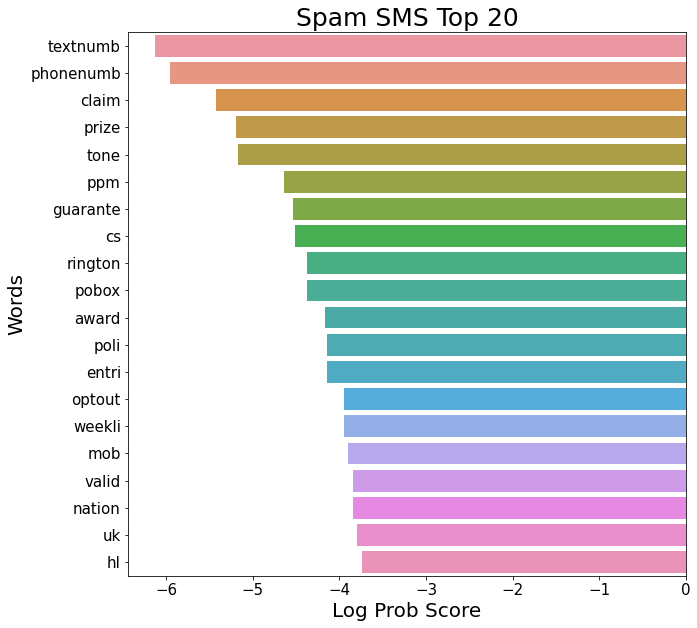

In [195]:
plt.figure(figsize=(10,10))
plt.title('Spam SMS Top 20',fontsize=25)

sns.barplot(data=nb_eval.sort_values(by='EvalScore').head(20),x='EvalScore',y='Word',orient='h')

plt.xlabel('Log Prob Score',fontsize=20)
plt.ylabel('Words',fontsize=20)
plt.tick_params(labelsize=15)

In [196]:
nb_eval.sort_values(by='EvalScore',ascending=False).head(20) #if the eval score is more positive the word leans towards Ham SMS

,Spam,Ham,Word,EvalScore
2698,-5.558713,-9.582662,lor,4.023950
1081,-5.597628,-9.582662,da,3.985034
4031,-5.629889,-9.582662,say,3.952773
2571,-5.818789,-9.582662,later,3.763873
162,-6.157244,-9.582662,amp,3.425418
3992,-6.171230,-9.582662,said,3.411432
2995,-6.214402,-9.582662,morn,3.368260
3801,-6.275027,-9.582662,realli,3.307635
4251,-6.306776,-9.582662,sleep,3.275887
4568,-6.306776,-9.582662,sure,3.275887


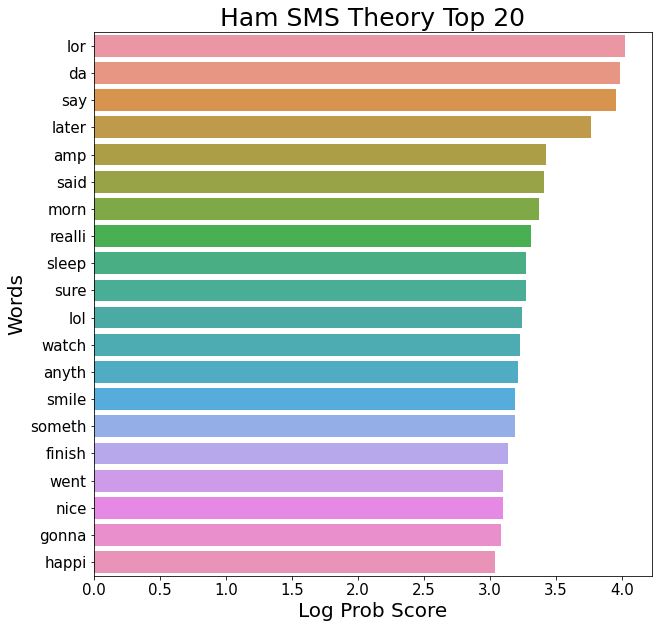

In [198]:
plt.figure(figsize=(10,10))
plt.title('Ham SMS Theory Top 20',fontsize=25)

sns.barplot(data=nb_eval.sort_values(by='EvalScore',ascending=False).head(20).head(20),x='EvalScore',y='Word',orient='h')

plt.xlabel('Log Prob Score',fontsize=20)
plt.ylabel('Words',fontsize=20)
plt.tick_params(labelsize=15)

From the log probability evaluation I calculated the eval score where the more positive the number the more that word leans to predicting the SMS as spam, while the more negative the number the more that word leans to predicting the post as Ham SMS.